In [4]:
import os
import time

import backoff
import openai
from openai import (
    APIConnectionError,
    APIError,
    RateLimitError,
    # ServiceUnavailableError,
    # InvalidRequestError,
    AzureOpenAI
)
import pandas as pd 
from datetime import datetime
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

import base64

import logging

import json 
import pandas as pd
from collections import Counter 

# Set up logging

import logging
import re 
# ANSI escape sequences for colors
colors = {
    'WARNING': '\033[93m',  # Yellow
    'INFO': '\033[92m',     # Green
    'DEBUG': '\033[94m',    # Blue
    'CRITICAL': '\033[91m', # Red
    'ERROR': '\033[91m',    # Red
    'ENDC': '\033[0m',      # Reset color
}

class CustomFormatter(logging.Formatter):
    def format(self, record):
        log_fmt = f"{colors[record.levelname]}%(levelname)s: %(message)s{colors['ENDC']}"
        formatter = logging.Formatter(log_fmt)
        return formatter.format(record)

# Setting up logging
logger = logging.getLogger('my_logger')
handler = logging.StreamHandler()
handler.setFormatter(CustomFormatter())
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

# Test messages
logger.debug("This is a debug message")
logger.info("This is an info message")
logger.warning("This is a warning message")
logger.error("This is an error message")

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


class Engine:
    def __init__(self) -> None:
        pass

    def tokenize(self, input):
        return self.tokenizer(input)


DEBUG: This is a debug message
DEBUG: This is a debug message
INFO: This is an info message
INFO: This is an info message
ERROR: This is an error message
ERROR: This is an error message


In [5]:

class OpenaiAzureEngine(Engine):
    def __init__(
            self,
            api_key=None,
            endpoint=None,
            stop=["\n\n"],
            rate_limit=-1,
            model='guiagents',
            temperature=0,
            **kwargs,
    ) -> None:
        """Init an OpenAI GPT/Codex engine with AzureOpenAI 

        Args:
            api_key (_type_, optional): Auth key from OpenAI. Defaults to None.
            stop (list, optional): Tokens indicate stop of sequence. Defaults to ["\n"].
            rate_limit (int, optional): Max number of requests per minute. Defaults to -1.
            model (_type_, optional): Model family. Defaults to None.
        """
        assert (
                os.getenv("AZURE_OPENAI_API_KEY", api_key) is not None
        ), "must pass on the api_key or set OPENAI_API_KEY in the environment"
        if api_key is None:
            api_key = os.getenv("AZURE_OPENAI_API_KEY", api_key)
        if isinstance(api_key, str):
            self.api_keys = [api_key]
        elif isinstance(api_key, list):
            self.api_keys = api_key
        else:
            raise ValueError("api_key must be a string or list")

        if endpoint is None:
            endpoint = os.getenv("AZURE_OPENAI_API_BASE", api_key)
        if isinstance(endpoint, str):
            self.endpoints = [endpoint]
        elif isinstance(endpoint, list):
            self.endpoints = endpoint
        else:
            raise ValueError("endpoint must be a string or list")
        
        self.stop = stop
        self.temperature = temperature
        self.model = model
        # convert rate limit to minmum request interval
        self.request_interval = 0 if rate_limit == -1 else 60.0 / rate_limit
        self.next_avil_time = [0] * len(self.api_keys)
        self.current_key_idx = 0
        self.client = AzureOpenAI(
            azure_endpoint = self.endpoints[0], 
            api_key=self.api_keys[0],  
            api_version="2023-12-01-preview"
        )
        self.opponent_client = AzureOpenAI(
            azure_endpoint = self.endpoints[0], 
            api_key=self.api_keys[0],  
            api_version="2023-12-01-preview"
        )
        self.system_prompt = '''You are a debate agent. You will be provided an image and asked a question. You will try to answer the question to the best of your abilities. You will have a competitor. You do not always have to agree with your competitor. Note: no more information can be provided, the debate has to be settled based on the available evidence.'''
        self.moderator_system_prompt = '''You are a moderator. There will be two debaters involved in a competition to answer a question with an image as the context. At the end of each round, you will evaluate the candidates' answers. If you think one of the debater is correct, you should end your response with Final Answer: <The Final Correct Answer based on the debate>. If not, the debate goes on. Note: no more information can be provided, the debate has to be settled based on the available evidence.'''
        self.actor_prompt = '''You will be provded an image and asked a question about it. You will try to answer the question to the best of your abilities. You will receive feedback from a critic if your answer is incorrect. You will have to provide a new answer based on the feedback.'''
        self.critic_prompt = '''You are a critic in an image question answer challenge. You will be provided with a question about an image and my answer to the question. If you think my answer is correct just say Answer:True. Else provide me with feedback so I can come up with a better answer.'''
        Engine.__init__(self, **kwargs)

    def encode_image(self, image_path):
        with open(self, image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')

    @backoff.on_exception(
        backoff.expo,
        (APIError, RateLimitError, APIConnectionError),
    )
    def generate(self, prompt: list = None, max_new_tokens=4096, temperature=None, model=None, image_path=None,
                 ouput__0=None, turn_number=0, **kwargs):
        self.current_key_idx = (self.current_key_idx + 1) % len(self.api_keys)
        start_time = time.time()
        if (
                self.request_interval > 0
                and start_time < self.next_avil_time[self.current_key_idx]
        ):
            time.sleep(self.next_avil_time[self.current_key_idx] - start_time)
        openai.api_key = self.api_keys[self.current_key_idx]


        
        base64_image = encode_image(image_path)
        # Assume one turn dialogue
        qa_input = [
            {"role": "system", "content": [{"type": "text", "text": self.system_prompt}]},
            {"role": "user",
                "content": [{"type": "text", "text": prompt}, {"type": "image_url", "image_url": {"url":
                                                                                                    f"data:image/jpeg;base64,{base64_image}",
                                                                                                "detail": "high"},
                                                                }]},
        ]
        response = self.client.chat.completions.create(
            model=model if model else self.model,
            messages=qa_input,
            max_tokens=max_new_tokens if max_new_tokens else 4096,
            temperature=temperature if temperature else self.temperature,
            **kwargs,
        )

        answer = response.choices[0].message.content

        return answer 
    
    def sanitize_filename(self, text):
        """Generate a sanitized filename from the debate question."""
        # Shorten the text to the first 50 characters and remove non-filename safe characters
        short_text = text[:50]
        return re.sub(r'[^a-zA-Z0-9_\-\s]', '', short_text).replace(' ', '_')

    def debate(self, prompt: list = None, max_new_tokens=4096, temperature=None, model=None, image_path=None,
                 ouput__0=None, turn_number=0, rounds=4, **kwargs):
        
        self.current_key_idx = (self.current_key_idx + 1) % len(self.api_keys)
        start_time = time.time()
        if (
                self.request_interval > 0
                and start_time < self.next_avil_time[self.current_key_idx]
        ):
            time.sleep(self.next_avil_time[self.current_key_idx] - start_time)

        base64_image = encode_image(image_path)  
        aff_latest_argument = 'Has not had a chance to respond yet.'
        neg_latest_argument = 'Has not had a chance to respond yet.'
        aff_arguments = []
        neg_arguments = []
        moderator_responses = []

        aff_agent_messages = [
                {"role": "system", "content": [{"type": "text", "text": self.system_prompt}]},]
            
        neg_agent_messages = [
                {"role": "system", "content": [{"type": "text", "text": self.system_prompt}]},]
        
        moderator_messages = [
                {"role": "system", "content": [{"type": "text", "text": self.moderator_system_prompt}]},]
        
        aff_latest_argument = ''
        neg_latest_argument = ''
        conversation_log = []
        for round in range(rounds):
            # Prompt for affirmative agent
            aff_agent_input_text = f"Question: {prompt}."
            
            # Provide the prompt to the affirmative agent along with the image 
            if round == 0:
                # Include the image in the initial round 
                aff_agent_messages.append({"role": "user",
                 "content": [{"type": "text", "text": aff_agent_input_text}, {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}", "detail": "high"}, }]},)
            else:
                aff_agent_messages.append({"role": "user",
                 "content": [{"type": "text", "text": f"Your opponent said: {neg_latest_argument}"},]})

            logger.debug(f"AFFIRMATIVE AGENT INPUT: {aff_agent_input_text}")
            
            # Get a response from the affirmative agent
            aff_latest_argument = self.client.chat.completions.create(
                model=model if model else self.model,
                messages=aff_agent_messages,
                max_tokens=max_new_tokens if max_new_tokens else 4096,
                temperature=temperature if temperature else self.temperature,
                **kwargs,
            ).choices[0].message.content

            aff_agent_messages.append({"role": "assistant", "content": [{"type": "text", "text": aff_latest_argument}]})
            
            logger.debug(f"AFFIRMATIVE AGENT OUTPUT: {aff_latest_argument}")            

            # Provide the prompt to the negative agent along with the image
            if round == 0:
                neg_agent_input_text = f"Question: {prompt}. Your opponent said: {aff_latest_argument}. You disagree with them. State your reasons and your answer."
                # Include the image in the initial round 
                neg_agent_messages.append({"role": "user",
                 "content": [{"type": "text", "text": neg_agent_input_text}, {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}", "detail": "high"}, }]},)
            else:
                neg_agent_input_text = f"Your opponent said: {aff_latest_argument}. You disagree with them. State your reasons and your answer."
                neg_agent_messages.append({"role": "user",
                 "content": [{"type": "text", "text": neg_agent_input_text},]})
                
            
            logger.error(f"NEGATIVE AGENT INPUT: {neg_agent_input_text}")

            # Get a response from the negative agent
            neg_latest_argument = self.client.chat.completions.create(
                model=model if model else self.model,
                messages=neg_agent_messages,
                max_tokens=max_new_tokens if max_new_tokens else 4096,
                temperature=temperature if temperature else self.temperature,
                **kwargs,
            ).choices[0].message.content

            logger.error(f"NEGATIVE AGENT: {neg_latest_argument}")

            neg_agent_messages.append({"role": "assistant", "content": [{"type": "text", "text": neg_latest_argument}]})


            # Prompt for moderator
            moderator_input_text = f"Question: {prompt}. Debater 1 argues: {aff_latest_argument}. Debater 2 argues argues: {neg_latest_argument}"

            # Provide the prompt to the moderator along with the image

            if round == 0:
                # Include the image in the initial round 
                moderator_messages.append({"role": "user",
                 "content": [{"type": "text", "text": moderator_input_text}, {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}", "detail": "high"}, }]},)
            elif round == rounds - 1:
               moderator_messages.append({"role": "user",
                 "content": [{"type": "text", "text": moderator_input_text + ' You must decide an answer this round since its the last round of debate.'},]}) 
            else:
                moderator_messages.append({"role": "user",
                 "content": [{"type": "text", "text": moderator_input_text},]})
                
            logger.info(f"MODERATOR INPUT: {moderator_input_text}")
            print(f"{bcolors.WARNING}{moderator_input_text}{bcolors.ENDC}")

            # Get a response from the moderator
            moderator_response = self.client.chat.completions.create(
                model=model if model else self.model,
                messages=moderator_messages,
                max_tokens=max_new_tokens if max_new_tokens else 4096,
                temperature=temperature if temperature else self.temperature,
                **kwargs,
            ).choices[0].message.content

            moderator_messages.append({"role": "assistant", "content": [{"type": "text", "text": moderator_response}]})

  
            logger.info(f"MODERATOR OUTPUT: {moderator_response}")

            conversation_log.append("Affirmative agent says: " + aff_latest_argument)
            conversation_log.append("Negative agent says: " + neg_latest_argument)
            conversation_log.append("Moderator says: " + moderator_response)    

            if 'Answer:' in moderator_response:
                logger.info("ANSWER found in moderator response")
                break  
        # Generating a sanitized file name using the prompt
        sanitized_filename = self.sanitize_filename(prompt)
        # Get current time stamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        # Filename with timestamp
        filename_with_timestamp = f"{sanitized_filename}_{timestamp}_debate.txt"
        
        # Writing the conversation to a text file with the sanitized filename
        with open(sanitized_filename, "w") as file:
            for entry in conversation_log:
                file.write(entry + "\n")
        print([moderator_response, aff_latest_argument, neg_latest_argument])
        return [moderator_response, aff_latest_argument, neg_latest_argument]


    def generate_with_critic(self, prompt: list = None, max_new_tokens=4096, temperature=None, model=None, image_path=None, **kwargs):

        self.current_key_idx = (self.current_key_idx + 1) % len(self.api_keys)
        start_time = time.time()

        if (
                self.request_interval > 0
                and start_time < self.next_avil_time[self.current_key_idx]
        ):
            time.sleep(self.next_avil_time[self.current_key_idx] - start_time)

        base64_image = encode_image(image_path)


        critic_response = ''
        actor_prompt = [
                {"role": "system", "content": [{"type": "text", "text": self.actor_prompt}]},
        ]
        rounds = 0
        while 'Answer:True' not in critic_response:

            if rounds == 0:
                actor_prompt.append({"role": "user",
                "content": [{"type": "text", "text": prompt}, {"type": "image_url", "image_url": {"url":
                                                                                                        f"data:image/jpeg;base64,{base64_image}",
                                                                                                    "detail": "high"}, }]})
            else:
                actor_prompt.append({"role": "user",
                "content": [{"type": "text", "text": f"Your answer was: {actor_response}. The critic said: {critic_response}. Please try again"}, {"type": "image_url", "image_url": {"url":
                                                                                                        f"data:image/jpeg;base64,{base64_image}",
                                                                                                    "detail": "high"}, }]})
            actor_response_object = self.client.chat.completions.create(
                model=model if model else self.model,
                messages=actor_prompt,
                max_tokens=max_new_tokens if max_new_tokens else 4096,
                temperature=temperature if temperature else self.temperature,
                **kwargs,
            )
            actor_response = actor_response_object.choices[0].message.content


            critic_input = f"Question: {prompt}. My answer: {actor_response}."
            
            critic_prompt = [
                {"role": "system", "content": [{"type": "text", "text": self.critic_prompt}]},
                {"role": "user",
                "content": [{"type": "text", "text": critic_input}, {"type": "image_url", "image_url": {"url":
                                                                                                        f"data:image/jpeg;base64,{base64_image}",
                                                                                                    "detail": "high"}, }]},]

            critic_response_object = self.opponent_client.chat.completions.create(
                    model=model if model else self.model,
                    messages=critic_prompt,
                    max_tokens=max_new_tokens if max_new_tokens else 4096,
                    temperature=temperature if temperature else self.temperature,
                    **kwargs,
                )
            critic_response = critic_response_object.choices[0].message.content
        
        return actor_response







        
    # def generate_with_critic(self, prompt: list = None, max_new_tokens=4096, temperature=None, model=None, image_path=None,
    #              ouput__0=None, turn_number=0, **kwargs):
    #     self.current_key_idx = (self.current_key_idx + 1) % len(self.api_keys)
    #     start_time = time.time()
    #     if (
    #             self.request_interval > 0
    #             and start_time < self.next_avil_time[self.current_key_idx]
    #     ):
    #         time.sleep(self.next_avil_time[self.current_key_idx] - start_time)
    #     prompt0 = prompt[0]
    #     prompt1 = prompt[1]
    #     prompt2 = prompt[2]

    #     # Reasoning Case 
    #     if turn_number == 0:
    #         base64_image = encode_image(image_path)
    #         # Assume one turn dialogue
    #         prompt1_input = [
    #             {"role": "system", "content": [{"type": "text", "text": prompt0}]},
    #             {"role": "user",
    #              "content": [{"type": "text", "text": prompt1}, {"type": "image_url", "image_url": {"url":
    #                                                                                                     f"data:image/jpeg;base64,{base64_image}",
    #                                                                                                 "detail": "high"},
    #                                                              }]},
    #         ]
    #         response1 = self.client.chat.completions.create(
    #             model=model if model else self.model,
    #             messages=prompt1_input,
    #             max_tokens=max_new_tokens if max_new_tokens else 4096,
    #             temperature=temperature if temperature else self.temperature,
    #             **kwargs,
    #         )

    #         answer1 = response1.choices[0].message.content

    #         return answer1
        
    #     # Grounding Case 
    #     elif turn_number == 1:
    #         base64_image = encode_image(image_path)
    #         actor_prompt = [
    #             {"role": "system", "content": [{"type": "text", "text": prompt0}]},
    #             {"role": "user",
    #             "content": [{"type": "text", "text": prompt1}, {"type": "image_url", "image_url": {"url":
    #                                                                                                     f"data:image/jpeg;base64,{base64_image}",
    #                                                                                                 "detail": "high"}, }]},
    #             {"role": "assistant", "content": [{"type": "text", "text": f"\n\n{ouput__0}"}]},
    #             {"role": "user", "content": [{"type": "text", "text": prompt2}]}, ]
            
    #         while 'Match: Yes' not in critic_response: 
    #             actor_response_object = self.client.chat.completions.create(
    #                 model=model if model else self.model,
    #                 messages=actor_prompt,
    #                 max_tokens=max_new_tokens if max_new_tokens else 4096,
    #                 temperature=temperature if temperature else self.temperature,
    #                 **kwargs,
    #             )
    #             actor_response = actor_response_object.choices[0].message.content

    #             critic_system_prompt = '''You are a very strict critic in an image grounding task. I will provide you with an image, a description of an element I am looking for in the image, and my choice of a specific target element in the image. All target elements in the image are marked by a red bounding box and has a white uppercase letter on a black background at the bottom left corner of the bounding box, which is positioned closely next to the bounding box. You need to tell me if the letter I have selected matches the element that I want to select based on the description. Give your reasoning and end your response with "Match: Yes" or "Match: No".'''

    #             # user_output is ouput__0 concatenated with everything in response2.choices[0].message.content after (Final Answer)
    #             critic_input = ouput__0 + actor_response.split("(Final Answer)")[-1]
                
    #             critic_prompt = [
    #                 {"role": "system", "content": [{"type": "text", "text": critic_system_prompt}]},
    #                 {"role": "user",
    #                 "content": [{"type": "text", "text": critic_input}, {"type": "image_url", "image_url": {"url":
    #                                                                                                         f"data:image/jpeg;base64,{base64_image}",
    #                                                                                                     "detail": "high"}, }]},]

    #             critic_response_object = self.opponent_client.chat.completions.create(
    #                     model=model if model else self.model,
    #                     messages=critic_prompt,
    #                     max_tokens=max_new_tokens if max_new_tokens else 4096,
    #                     temperature=temperature if temperature else self.temperature,
    #                     **kwargs,
    #                 )
    #             critic_response = critic_response_object.choices[0].message.content 
    #             actor_prompt.append({"role": "assistant", "content": [{"type": "text", "text": actor_response.split("(Final Answer)")[-1]}]}) 
    #             actor_prompt.append({"role": "user", "content": [{"type": "text", "text": critic_response + "\n\n The letter you have selected is either not the target element or does not exist in the image. Please try again. "}]}) 




    #         return actor_response

In [ ]:
import backoff
import openai
from openai import (
    APIConnectionError,
    APIError,
    RateLimitError,
    AzureOpenAI,
    OpenAI
)


class LMMEngine:
    pass 

class LLMEngineOpenAI(LMMEngine):
    def __init__(self, api_key=None, model=None, rate_limit=-1):
        # model must be provided 
        assert model is not None, "model must be provided"
        self.model = model

        # api_key must be provided
        assert (
                os.getenv("OPENAI_API_KEY", api_key) is not None
        ), "must pass on the api_key or set OPENAI_API_KEY in the environment"
        if api_key is None:
            api_key = os.getenv("OPENAI_API_KEY", api_key)
            # if not found in the environment, raise an error
            if api_key is None:
                raise ValueError("An API Key needs to be provided in either the api_key parameter or as an environment variable named OPENAI_API_KEY") 
        else:
            api_key = api_key
        
        # convert rate limit to minmum request interval
        self.request_interval = 0 if rate_limit == -1 else 60.0 / rate_limit

        self.llm_client = OpenAI(
            api_key=api_key,  
            model=self.model
        )

    def generate(self, messages, temperature=0., max_new_tokens=None, **kwargs):
        '''Generate the next message based on previous messages'''
        return self.llm_client.chat.completions.create(
            model=self.model,
            messages=messages,
            max_tokens=max_new_tokens if max_new_tokens else 4096,
            temperature=temperature
            **kwargs,
        )

class LMMEngineAzureOpenAI(LMMEngine):
    def __init__(self, api_key=None, azure_endpoint=None, model=None, api_version="2023-12-01-preview", rate_limit=-1):
        
        # model must be provided 
        assert model is not None, "model must be provided"
        self.model = model
        
        # api version must be provided
        assert api_version is not None, "api_version must be provided"
        self.api_version = api_version

        # api_key must be provided
        assert (
                os.getenv("OPENAI_API_KEY", api_key) is not None
        ), "must pass on the api_key or set OPENAI_API_KEY in the environment"
        if api_key is None:
            api_key = os.getenv("AZURE_OPENAI_API_KEY", api_key)
            # if not found in the environment, raise an error
            if api_key is None:
                raise ValueError("An API Key needs to be provided in either the api_key parameter or as an environment variable named OPENAI_API_KEY") 
        else:
            api_key = api_key

        # azure endpoint must be provided 
        if azure_endpoint is None:
            azure_endpoint = os.getenv("AZURE_OPENAI_API_BASE", api_key)
            # if not found in the environment, raise an error
            if azure_endpoint is None:
                raise ValueError("An Azure API endpoint needs to be provided in either the endpoint parameter or as an environment variable named OPENAI_API_BASE")
        else:
            azure_endpoint = azure_endpoint

        # convert rate limit to minmum request interval
        self.request_interval = 0 if rate_limit == -1 else 60.0 / rate_limit

        self.llm_client = AzureOpenAI(
            azure_endpoint = self.azure_endpoint, 
            api_key=self.azure_api_key,  
            api_version=self.api_version
        )

    def generate(self, messages, temperature=0., max_new_tokens=None, **kwargs):
        '''Generate the next message based on previous messages'''
        return self.llm_client.chat.completions.create(
            model=self.model,
            messages=messages,
            max_tokens=max_new_tokens if max_new_tokens else 4096,
            temperature=temperature
            **kwargs,
        )
    

In [ ]:
# Message Centered Agent 
class LMMAgent:
    def __init__(self, engine_params=None, system_prompt=None, engine=None):
        if engine==None:
            if engine_params is not None:
                if engine_params['engine_type'] == 'openai':
                    self.engine = LLMEngineOpenAI(**engine_params)
                elif engine_params['engine_type'] == 'azure':
                    self.engine = LMMEngineAzureOpenAI(**engine_params)
                else:
                    raise ValueError("engine_type must be either 'openai' or 'azure'")
            else:
                raise ValueError("engine_params must be provided")
        else:
            self.engine = engine

        self.messages = [] # Empty messages 
        
        if system_prompt:
            self.add_system_prompt(system_prompt)
        else:
            self.add_system_prompt("You are a helpful multimodal assistant.")
    
    def add_system_prompt(self, system_prompt):
        self.system_prompt = system_prompt
        if len(self.messages) > 0:
            self.messages[0] = {"role": "system", "content": [{"type": "text", "text": self.system_prompt}]}
        
    def add_message(self, role, text_content=None, image_content=None, message_content_type="text"):
        '''Add a new message to the list of messages'''
        if image_content:
            message = {"role": role, "content": [{"type":message_content_type, "text": text_content}, {"type": "image_url", "image_url": {"url": image_content, "detail": "high"}}]}
        else:
            message = {"role": role, "content": [{"type":message_content_type, "text": text_content}]}

        # if message directly arrives as a string 
        if isinstance(message, str):
            message = {"role": role, "content": [{"type":message_content_type, "text": message}]}
        self.messages.append(message)
    
    def get_response(self, user_message=None, image=None, messages=None, temperature=0., max_new_tokens=None, **kwargs):
        '''Generate the next response based on previous messages'''
        if messages is None:
            messages = self.messages 
        if user_message:
            messages.append({"role": "user", "content": [{"type": "text", "text": user_message}]})
        return self.engine.generate(messages, temperature=temperature, max_new_tokens=max_new_tokens, **kwargs)

    
        

In [ ]:

# Debate about a question about an image in the hallusion bench dataset 
def debate(identifier, n_rounds, debater_system_prompt, moderator_system_prompt, moderator, prompt, image_path):
    # Instantiate the agents 

    engine_params = {
        "engine_type": "azure",
        "model": "gui-agents",
    }

    aff_agent = LMMAgent(system_prompt=debater_system_prompt, engine_params=engine_params)
    neg_agent = LMMAgent(system_prompt=debater_system_prompt, engine_params=engine_params)
    mod_agent = LMMAgent(system_prompt=moderator_system_prompt, engine_params=engine_params)


    conversation_history = []

    for round in n_rounds:
        # Start the debate 
        # Only need to pass the image and set the tone of the conversation (disagreement) in the first turn 
        if round == 0:

            # The image and question is passed as input to the affirmative agent
            aff_agent.add_message(prompt, image_content=image_path)
            conversation_history.append(f"Question: {prompt}")
            aff_response = aff_agent.get_response()
            conversation_history.append(f"Affirmative Agent: {aff_response}")
            aff_agent.add_message(aff_response)

            # The affirmative agent's response is passed to the negative agent
            neg_agent_input = f"{prompt}. My response: {aff_response}. You disagree with me. State your reasons and your answer."
            neg_agent.add_messages(neg_agent_input)
            neg_response = neg_agent.get_response()
            conversation_history.append(f"Negative Agent: {neg_response}")
            neg_agent.add_message(neg_response)

            moderator.add_message(f"{prompt}. Debater 1 argues: {aff_response}. Debater 2 argues: {neg_response}", image_content=image_path)
            moderator_response = moderator.get_response()
            conversation_history.append(f"Moderator: {moderator_response}")

            if 'Final Answer' in moderator_response:
                break
        else:
            # The negative agent's response is passed to the affirmative agent
            aff_agent.add_message(neg_response)
            aff_response = aff_agent.get_response()
            conversation_history.append(f"Affirmative Agent: {aff_response}")

            # The affirmative agent's response is passed to the negative agent
            neg_agent.add_message(aff_response)
            neg_response = neg_agent.get_response()
            conversation_history.append(f"Negative Agent: {neg_response}")

            if round == n_rounds - 1:
                moderator.add_message(f"{prompt}. Debater 1 argues: {aff_response}. Debater 2 argues: {neg_response}. You must decide an answer this round since its the last round of debate.")
            else:
                moderator.add_message(f"{prompt}. Debater 1 argues: {aff_response}. Debater 2 argues: {neg_response}")

            moderator_response = moderator.get_response()
            conversation_history.append(f"Moderator: {moderator_response}")

            if 'Final Answer' in moderator_response:
                break
    # extract everything after Final Answer from moderator_response 
    final_answer = moderator_response.split("Final Answer: ")[-1]

    # Save conversation history in a json log file 
    with open(f"conversation_history_{identifier}.json", "w") as f:
        json.dump(conversation_history, f)

    return final_answer 
        
    




In [6]:
engine = OpenaiAzureEngine()
hallusion_path = '/data4/saaket/hallusion_bench/'


In [1]:
a = ["No, there are no grey points at the intersections of the white lines; it is an optical illusion.", "There are no grey points at the intersections of the white lines in the provided image; it is a modified version of the Hermann Grid illusion with the grey spots removed where the white circles are placed.", "Yes, the green line and the red line are the same length in the image.", "Yes, the green line and the red line are the same length in the image.", "Yes, the lengths of the vertical line and the horizontal line are the same.", "The debate cannot be settled conclusively based on the available visual information alone.", "Yes, the black line aligns with the blue line.", "Yes, the two yellow lines are the same length.", "The top yellow line is not longer than the bottom yellow line; they are the same length.", "The top yellow line is not longer than the bottom yellow line; they are the same length, and the perceived difference is due to the Ponzo illusion."]

len(a)

10

In [1]:
import json 
import pandas as pd 
from collections import Counter 
with open('/data4/saaket/hallusion_bench/HallusionBench.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)


# What is the size of the df and the distribution of categories and subcategories
print(len(df))
print(Counter(df['category']))
print(Counter(df['subcategory']))

1129
Counter({'VD': 591, 'VS': 538})
Counter({'chart': 206, 'ocr': 170, 'video': 170, 'table': 155, 'illusion': 144, 'math': 108, 'map': 96, 'figure': 80})


In [3]:
import pandas as pd

# Let's only keep the visual dependent examples (VD)
df_vd = df.loc[df['category'] == 'VD']

# This code will sample n_samples examples from each subcategory
n_samples = 5
random_seed = 42  # Set the seed for reproducibility

df_vd_illusion_only = df_vd[df_vd['subcategory'] == 'illusion']
df_vd_illusion_selected_sample_keys = df_vd_illusion_only[~df_vd_illusion_only['sample_note'].isin(['circle', 'line'])]
# sample_df = df_vd_illusion_selected_sample_keys.groupby('sample_note', group_keys=False).apply(lambda x: x.sample(min(len(x), n_samples), random_state=random_seed))

In [4]:
df_vd_illusion_selected_sample_keys

,category,subcategory,visual_input,set_id,figure_id,sample_note,question_id,question,gt_answer_details,gt_answer,filename
544,VD,illusion,1,1,0,box,0,Is the right grey box larger than the left gre...,The right grey box is the same size as the lef...,0,./VD/illusion/1_0.png
545,VD,illusion,1,1,0,box,1,Is the right grey box smaller than the left gr...,The right grey box is the same size as the lef...,0,./VD/illusion/1_0.png
546,VD,illusion,1,1,0,box,2,Is the right grey box the same size as the lef...,The right grey box is the same size as the lef...,1,./VD/illusion/1_0.png
547,VD,illusion,2,1,1,box,0,Is the right grey box larger than the left gre...,The right grey box is smaller than the left gr...,0,./VD/illusion/1_1.png
548,VD,illusion,2,1,1,box,1,Is the right grey box smaller than the left gr...,The right grey box is smaller than the left gr...,1,./VD/illusion/1_1.png
...,...,...,...,...,...,...,...,...,...,...,...
619,VD,illusion,2,17,1,man,1,Are these two men in the images different heig...,"Yes, these two men are different height.",1,./VD/illusion/17_1.png
620,VD,illusion,1,18,0,man,0,Are these two men in the images the same heigh...,"Yes, these two men are the same height.",1,./VD/illusion/18_0.png
621,VD,illusion,1,18,0,man,1,Are these two men in the images different heig...,"No, these two men are not different height.",0,./VD/illusion/18_0.png
622,VD,illusion,2,18,1,man,0,Are these two men in the images the same heigh...,"No, these two men are not the same height.",0,./VD/illusion/18_1.png


In [7]:
list(sample_df['question'][:20])

['Is the right grey box larger than the left grey box?',
 'Is the right grey box smaller than the left grey box?',
 'Is the right grey box the same size as the left grey box?',
 'Is the right grey box the same size as the left grey box?',
 'Is the right grey box smaller than the left grey box?',
 'The image shows a color illusion. Are two circles in the image the same color? Yes or No',
 'The image shows a color illusion. Are two circles in the image the same color? yes or no',
 'Is the black solid circle on the left larger than the black solid circle on the right?',
 'Are two circles in the image different color? Yes or No',
 'Is the right orange circle larger than the left orange circle?',
 'Are there any grey points actually in the intersection of the white lines?',
 'Are there any grey points actually in the intersection of the white lines?',
 'Are the green line and the red line the same length in the image? Yes or No',
 'Is the yellow line longer than the red line in the image? Y

In [50]:
count_by_sample_note = Counter(df_vd_illusion_only['sample_note'])

# Sample 5 keys from the above counter
sample_keys = list(count_by_sample_note.keys())[:5]
sample_keys

['circle', 'box', 'line', 'rail', 'grey_dot']

In [9]:
count_by_sample_note = Counter(df_vd_illusion_only['sample_note'])

# Sample 5 keys from the above counter
sample_keys = list(count_by_sample_note.keys())[:5]
sample_keys

['circle', 'box', 'line', 'rail', 'grey_dot']

In [53]:
Counter(sample_df['sample_note'])
# There we have a total of 25 example now 

Counter({'box': 5, 'circle': 5, 'grey_dot': 2, 'line': 5, 'rail': 5})

In [10]:
Counter(sample_df['sample_note'])
# There we have a total of 25 example now 

Counter({'box': 5, 'circle': 5, 'grey_dot': 2, 'line': 5, 'rail': 5})

In [1]:
# sample_df.to_csv('IllusionSamplesSmall.csv', index=False)
import pandas as pd 
sample_df = pd.read_csv('IllusionSamplesSmall.csv')

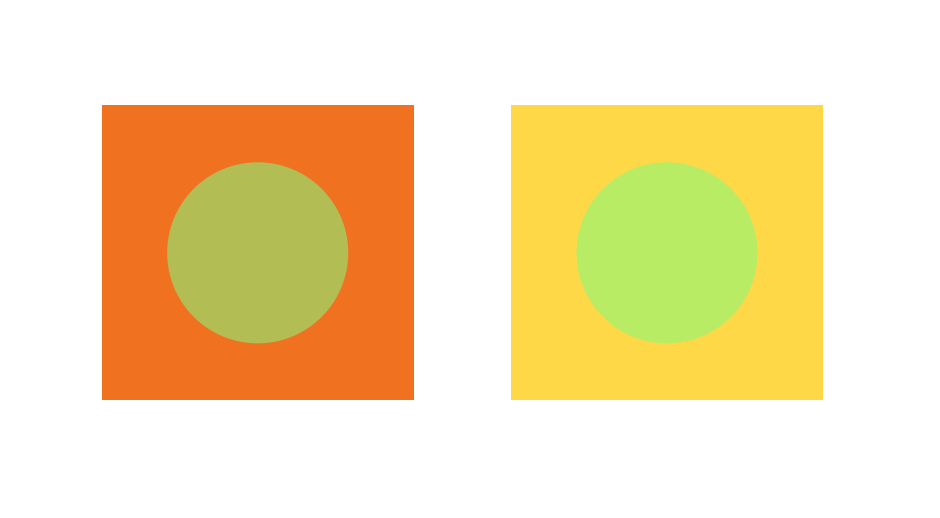

In [5]:
from PIL import Image
Image.open('/data4/saaket/hallusion_bench/VD/illusion/21_0.png')

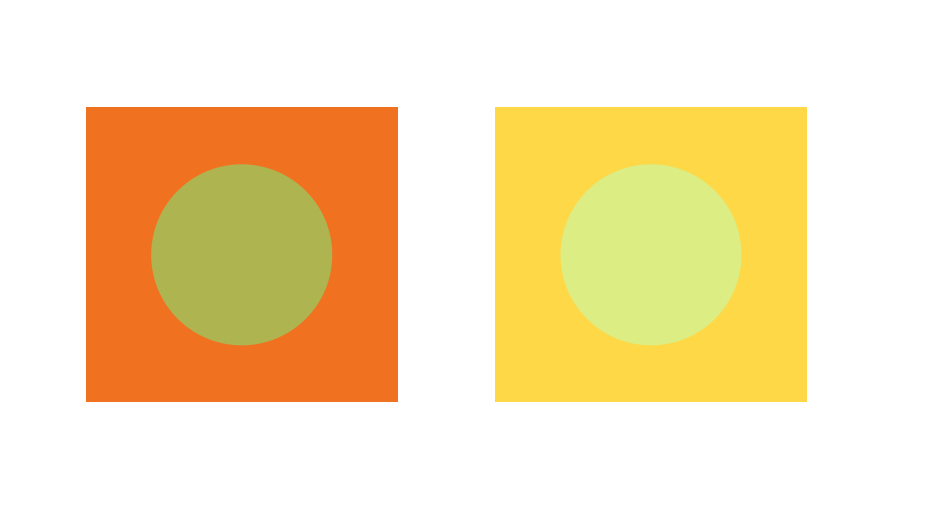

In [6]:
Image.open('/data4/saaket/hallusion_bench/VD/illusion/21_1.png')

In [12]:
sample_df

,category,subcategory,visual_input,set_id,figure_id,sample_note,question_id,question,gt_answer_details,gt_answer,filename,gpt4v_answer_generate,gpt4v_answer_debate
0,VD,illusion,1,1,0,box,0,Is the right grey box larger than the left gre...,The right grey box is the same size as the lef...,0,./VD/illusion/1_0.png,"No, the right grey box is not larger than the ...",LATEST AFF ARGUMENT: The two grey boxes in the...
1,VD,illusion,1,1,0,box,1,Is the right grey box smaller than the left gr...,The right grey box is the same size as the lef...,0,./VD/illusion/1_0.png,"No, the right grey box is not smaller than the...",LATEST AFF ARGUMENT: The two grey boxes in the...
2,VD,illusion,2,1,1,box,2,Is the right grey box the same size as the lef...,The right grey box is smaller than the left gr...,0,./VD/illusion/1_1.png,"Yes, the right grey box is the same size as th...","LATEST AFF ARGUMENT: Yes, the right grey box i..."
3,VD,illusion,1,1,0,box,2,Is the right grey box the same size as the lef...,The right grey box is the same size as the lef...,1,./VD/illusion/1_0.png,"Yes, the right grey box is the same size as th...","LATEST AFF ARGUMENT: Yes, the right grey box i..."
4,VD,illusion,2,1,1,box,1,Is the right grey box smaller than the left gr...,The right grey box is smaller than the left gr...,1,./VD/illusion/1_1.png,The two grey boxes in the image appear to be t...,LATEST AFF ARGUMENT: The image shows two grey ...
5,VD,illusion,2,21,1,circle,1,The image shows a color illusion. Are two circ...,"No, the two circles in the image are not the s...",0,./VD/illusion/21_1.png,"Yes, the two circles in the image are the same...","LATEST AFF ARGUMENT: Yes, the two circles in t..."
6,VD,illusion,1,19,0,circle,1,The image shows a color illusion. Are two circ...,"Yes, two circles are the same color.",1,./VD/illusion/19_0.png,"Yes, the two circles in the image are the same...","LATEST AFF ARGUMENT: Yes, the two circles in t..."
7,VD,illusion,1,11,0,circle,2,Is the black solid circle on the left larger t...,the black solid circle on the left the same si...,0,./VD/illusion/11_0.png,The black solid circles in the image appear to...,LATEST AFF ARGUMENT: The two black solid circl...
8,VD,illusion,2,21,1,circle,2,Are two circles in the image different color? ...,"Yes, the two circles in the image are differen...",1,./VD/illusion/21_1.png,"No, the two circles are the same color. The su...","LATEST AFF ARGUMENT: No, the two circles in th..."
9,VD,illusion,2,0,1,circle,1,Is the right orange circle larger than the lef...,The right orange circle is larger than the lef...,1,./VD/illusion/0_1.png,"No, the right orange circle is not actually la...",LATEST AFF ARGUMENT: The two orange circles ar...


In [17]:
sample_df

,category,subcategory,visual_input,set_id,figure_id,sample_note,question_id,question,gt_answer_details,gt_answer,filename,gpt4v_answer_generate,gpt4v_answer_debate,gpt4v_answer_debate_force_opposition
0,VD,illusion,1,1,0,box,0,Is the right grey box larger than the left gre...,The right grey box is the same size as the lef...,0,./VD/illusion/1_0.png,"No, the right grey box is not larger than the ...",LATEST AFF ARGUMENT: The two grey boxes in the...,DONE BEFORE
1,VD,illusion,1,1,0,box,1,Is the right grey box smaller than the left gr...,The right grey box is the same size as the lef...,0,./VD/illusion/1_0.png,"No, the right grey box is not smaller than the...",LATEST AFF ARGUMENT: The two grey boxes in the...,DONE BEFORE
2,VD,illusion,2,1,1,box,2,Is the right grey box the same size as the lef...,The right grey box is smaller than the left gr...,0,./VD/illusion/1_1.png,"Yes, the right grey box is the same size as th...","LATEST AFF ARGUMENT: Yes, the right grey box i...",DONE BEFORE
3,VD,illusion,1,1,0,box,2,Is the right grey box the same size as the lef...,The right grey box is the same size as the lef...,1,./VD/illusion/1_0.png,"Yes, the right grey box is the same size as th...","LATEST AFF ARGUMENT: Yes, the right grey box i...",DONE BEFORE
4,VD,illusion,2,1,1,box,1,Is the right grey box smaller than the left gr...,The right grey box is smaller than the left gr...,1,./VD/illusion/1_1.png,The two grey boxes in the image appear to be t...,LATEST AFF ARGUMENT: The image shows two grey ...,DONE BEFORE
5,VD,illusion,2,21,1,circle,1,The image shows a color illusion. Are two circ...,"No, the two circles in the image are not the s...",0,./VD/illusion/21_1.png,"Yes, the two circles in the image are the same...","LATEST AFF ARGUMENT: Yes, the two circles in t...",DONE BEFORE
6,VD,illusion,1,19,0,circle,1,The image shows a color illusion. Are two circ...,"Yes, two circles are the same color.",1,./VD/illusion/19_0.png,"Yes, the two circles in the image are the same...","LATEST AFF ARGUMENT: Yes, the two circles in t...",DONE BEFORE
7,VD,illusion,1,11,0,circle,2,Is the black solid circle on the left larger t...,the black solid circle on the left the same si...,0,./VD/illusion/11_0.png,The black solid circles in the image appear to...,LATEST AFF ARGUMENT: The two black solid circl...,DONE BEFORE
8,VD,illusion,2,21,1,circle,2,Are two circles in the image different color? ...,"Yes, the two circles in the image are differen...",1,./VD/illusion/21_1.png,"No, the two circles are the same color. The su...","LATEST AFF ARGUMENT: No, the two circles in th...",LATEST AFF ARGUMENT: The opponent's continued ...
9,VD,illusion,2,0,1,circle,1,Is the right orange circle larger than the lef...,The right orange circle is larger than the lef...,1,./VD/illusion/0_1.png,"No, the right orange circle is not actually la...",LATEST AFF ARGUMENT: The two orange circles ar...,"LATEST AFF ARGUMENT: No, the right orange circ..."


In [20]:
# Initialize an empty list to store the generated answers
from tqdm import tqdm 
def populate_answers(debate=False):
    gpt4v_answers = []

    # Loop through each row in the DataFrame
    for index, row in tqdm(sample_df.iterrows()):
        if index > 7:
            gpt4v_answers.append(row["gpt4v_answer_debate_force_opposition"])
            continue
        question = row['question']
        filename = row['filename']
        image_path = hallusion_path + filename
        
        # Log the values to visualize what is happening
        logging.warning(f"Generating answer for question: {question}")
        logging.warning(f"Using image path: {image_path}")
        
        
#         # Generate the answer using the engine
        if debate:
            out = engine.debate(prompt=question, image_path=image_path)
            print("OUT: ", out)
            answer, aff_argument, neg_argument = out
            gpt4v_answers.append(f"LATEST AFF ARGUMENT: {aff_argument}\n LATEST NEG ARGUMENT: {neg_argument}\n FINAL MODERATOR RESPONSE: {answer}")
        else:
            answer = engine.generate(prompt=question, image_path=image_path)
            gpt4v_answers.append(answer)
        
    
        # save gpt4v_answers to a file at each timestep, along with the question, the gt answer and the image path
        with open('gpt4v_answers.json', 'w') as f:
            json.dump(gpt4v_answers, f)
        
        # Log the generated answer
        logging.info(f"Generated answer: {answer}")
        
    return gpt4v_answers

gpt4v_answers = populate_answers(debate=True)
# # Assign the generated answers to a new column in the DataFrame
# # sample_df['gpt4v_answer'] = gpt4v_answers
sample_df['gpt4v_answer_debate_force_opposition_r2'] = gpt4v_answers

0it [00:00, ?it/s]WARNING:root:Generating answer for question: Is the right grey box larger than the left grey box?
DEBUG: AFFIRMATIVE AGENT INPUT: Question: Is the right grey box larger than the left grey box?.
DEBUG: AFFIRMATIVE AGENT INPUT: Question: Is the right grey box larger than the left grey box?.
DEBUG:my_logger:AFFIRMATIVE AGENT INPUT: Question: Is the right grey box larger than the left grey box?.
DEBUG: AFFIRMATIVE AGENT OUTPUT: Based on the image provided, it appears that the two grey boxes are identical in size. The illusion that one may be larger than the other is likely due to the Ebbinghaus illusion, a well-known optical illusion where the perception of the size of a central object is affected by the size and distance of surrounding objects. In this case, the grey box on the right is surrounded by smaller blue squares, which may make it appear larger than the grey box on the left, which is surrounded by larger blue squares. However, if we were to measure them, we woul

Question: Is the right grey box larger than the left grey box?. Debater 1 argues: Based on the image provided, it appears that the two grey boxes are identical in size. The illusion that one may be larger than the other is likely due to the Ebbinghaus illusion, a well-known optical illusion where the perception of the size of a central object is affected by the size and distance of surrounding objects. In this case, the grey box on the right is surrounded by smaller blue squares, which may make it appear larger than the grey box on the left, which is surrounded by larger blue squares. However, if we were to measure them, we would likely find that both grey boxes are the same size.. Debater 2 argues argues: I disagree with my opponent's assessment that the two grey boxes are identical in size. While it is true that the Ebbinghaus illusion can affect our perception of size, we cannot conclusively determine that the grey boxes are the same size without actual measurements. The image provi

INFO: MODERATOR OUTPUT: Debater 1 presents a strong argument based on the principles of the Ebbinghaus illusion, which is a well-documented phenomenon that can distort our perception of size. This argument is supported by the visual evidence in the image, where the grey box on the right is surrounded by smaller blue squares, which could make it appear larger than the grey box on the left, which is surrounded by larger blue squares.

Debater 2, on the other hand, argues that without actual measurements, we cannot conclusively determine the size of the grey boxes. This argument is also valid, as the image does not provide any scale or reference points for accurate measurement. However, Debater 2's argument does not sufficiently counter the likelihood of the Ebbinghaus illusion being the cause of any perceived size difference.

Given the context of the image and the principles of the Ebbinghaus illusion, Debater 1's argument is more convincing. The optical illusion is a plausible explanat

["Debater 1 presents a strong argument based on the principles of the Ebbinghaus illusion, which is a well-documented phenomenon that can distort our perception of size. This argument is supported by the visual evidence in the image, where the grey box on the right is surrounded by smaller blue squares, which could make it appear larger than the grey box on the left, which is surrounded by larger blue squares.\n\nDebater 2, on the other hand, argues that without actual measurements, we cannot conclusively determine the size of the grey boxes. This argument is also valid, as the image does not provide any scale or reference points for accurate measurement. However, Debater 2's argument does not sufficiently counter the likelihood of the Ebbinghaus illusion being the cause of any perceived size difference.\n\nGiven the context of the image and the principles of the Ebbinghaus illusion, Debater 1's argument is more convincing. The optical illusion is a plausible explanation for the percei

DEBUG: AFFIRMATIVE AGENT OUTPUT: The two grey boxes in the image appear to be an example of the Ebbinghaus illusion, also known as the Titchener circles illusion. This optical illusion involves a central shape (in this case, the grey boxes) surrounded by other shapes that affect the perception of the central shape's size. On the left, the grey box is surrounded by larger blue squares, which may make the grey box appear smaller than it is. On the right, the grey box is surrounded by smaller blue squares, which may make the grey box appear larger than it is.

Despite the illusion, if we were to measure the grey boxes, we would likely find that they are the same size. The illusion is a result of relative size perception and not an actual difference in size. Therefore, the right grey box is not smaller than the left grey box; they are perceptually affected by the surrounding squares but are physically the same size.
DEBUG: AFFIRMATIVE AGENT OUTPUT: The two grey boxes in the image appear to

Question: Is the right grey box smaller than the left grey box?. Debater 1 argues: The two grey boxes in the image appear to be an example of the Ebbinghaus illusion, also known as the Titchener circles illusion. This optical illusion involves a central shape (in this case, the grey boxes) surrounded by other shapes that affect the perception of the central shape's size. On the left, the grey box is surrounded by larger blue squares, which may make the grey box appear smaller than it is. On the right, the grey box is surrounded by smaller blue squares, which may make the grey box appear larger than it is.

Despite the illusion, if we were to measure the grey boxes, we would likely find that they are the same size. The illusion is a result of relative size perception and not an actual difference in size. Therefore, the right grey box is not smaller than the left grey box; they are perceptually affected by the surrounding squares but are physically the same size.. Debater 2 argues argues

INFO: MODERATOR OUTPUT: Debater 1 presents a strong argument based on the principles of the Ebbinghaus illusion, suggesting that the grey boxes are the same size but appear different due to the surrounding blue squares. This is a well-known perceptual phenomenon that can indeed make two identically sized objects appear different in size.

Debater 2, however, raises a valid point that without actual measurements or additional information, we cannot be certain that the grey boxes are the same size. The possibility that the image was designed to mimic the illusion while actually having differently sized grey boxes cannot be ruled out based on the evidence provided.

Given the arguments presented, the debate hinges on the assumption of the Ebbinghaus illusion versus the lack of empirical evidence to confirm the actual sizes of the grey boxes. Without the ability to measure the boxes or additional information to confirm their size, we cannot definitively conclude that the right grey box is 

Question: Is the right grey box smaller than the left grey box?. Debater 1 argues: While my opponent raises a valid point that without actual measurements we cannot be absolutely certain of the size of the grey boxes, the context of the image strongly suggests that it is an example of the Ebbinghaus illusion. This optical illusion is well-documented and is specifically designed to make identically sized central shapes appear different in size due to the relative size and distance of the surrounding shapes.

The consistency of the illusion across various instances and the fact that it is a common psychological phenomenon used to demonstrate the perception of relative size in humans lend credence to the assumption that the grey boxes are indeed the same size. It is a reasonable hypothesis, given the lack of any visual cues that would indicate manipulation or alteration of the standard parameters of the illusion.

Moreover, the design of the image, with the grey boxes centered within a sy

INFO: MODERATOR OUTPUT: Both debaters have presented compelling arguments. Debater 1 relies on the assumption that the image is a representation of the Ebbinghaus illusion, which is a well-known optical illusion that affects size perception. This debater argues that the symmetrical arrangement and the context of the image suggest that the grey boxes are the same size, and the perceived difference is due to the illusion.

Debater 2, on the other hand, emphasizes the need for empirical evidence to confirm the sizes of the grey boxes. This debater points out that without measurements or additional information, we cannot conclusively determine that the grey boxes are the same size, and the possibility of deliberate manipulation to mimic the illusion cannot be dismissed.

Given the arguments presented and the lack of empirical evidence, the debate remains unresolved. The image alone, without the ability to measure the grey boxes, does not provide enough information to definitively conclude 

Question: Is the right grey box smaller than the left grey box?. Debater 1 argues: My opponent's caution in not accepting the Ebbinghaus illusion at face value without empirical evidence is understandable. However, the burden of proof in this context leans towards the assumption that the image is a representation of the Ebbinghaus illusion until proven otherwise. The image's design, which closely mirrors the classic setup of the illusion, is a strong indicator that the grey boxes are intended to be the same size, and the perceived difference is a result of the cognitive biases induced by the surrounding squares.

While it is true that we cannot completely rule out the possibility of manipulation without direct measurement, Occam's razor—a problem-solving principle that suggests the simplest explanation is more likely the correct one—supports the idea that the image is a straightforward instance of the Ebbinghaus illusion rather than a complex deception with different-sized grey boxes. 

INFO: MODERATOR OUTPUT: Both debaters have made strong points. Debater 1 suggests that the design of the image, which mirrors the classic Ebbinghaus illusion setup, indicates that the grey boxes are likely the same size. This debater invokes Occam's razor, arguing that the simplest explanation—namely, that the image is a standard representation of the illusion—is more likely to be correct.

Debater 2, however, cautions against accepting the illusion at face value without empirical evidence. This debater points out that optical illusions are designed to challenge our perceptions and that the simplest explanation is not always the correct one in such cases. Debater 2 also suggests that the image could be a variation of the Ebbinghaus illusion, designed to test the observer's critical thinking or to demonstrate that perceptions can be manipulated.

Given the arguments presented, the debate hinges on the interpretation of the image in the context of the Ebbinghaus illusion and the need for

Question: Is the right grey box smaller than the left grey box?. Debater 1 argues: My opponent's insistence on the possibility of intentional deviation from the traditional Ebbinghaus illusion parameters to create a different effect is a point that invites skepticism and critical examination of visual information. It is true that without empirical evidence, we cannot claim absolute certainty about the sizes of the grey boxes. However, the context of the image and the principles of visual perception still provide a strong basis for the educated assumption that the grey boxes are the same size.

The Ebbinghaus illusion is a well-established phenomenon in which the context provided by surrounding shapes affects the perceived size of a central shape. The image in question is a classic representation of this illusion, and while it is possible that the creator could have deviated from the norm, there is no direct indication of such deviation. The absence of any cues that suggest intentional 

INFO: MODERATOR OUTPUT: Both debaters have presented their final arguments with careful consideration of the principles of visual perception and the nature of optical illusions.

Debater 1 has argued that the image likely represents a classic example of the Ebbinghaus illusion, suggesting that the grey boxes are the same size and that the perceived difference is due to the illusion. This debater has invoked the balance of probabilities and the typical presentation of such illusions as evidence for this interpretation.

Debater 2 has maintained that without empirical evidence, we cannot conclusively determine the sizes of the grey boxes based on perception alone. This debater has highlighted the potential for the image to be a variation of the Ebbinghaus illusion, designed to challenge assumptions and illustrate the fallibility of perception.

Given the arguments presented and the nature of the image, which is consistent with the Ebbinghaus illusion, the most reasonable interpretation, 

['Both debaters have presented their final arguments with careful consideration of the principles of visual perception and the nature of optical illusions.\n\nDebater 1 has argued that the image likely represents a classic example of the Ebbinghaus illusion, suggesting that the grey boxes are the same size and that the perceived difference is due to the illusion. This debater has invoked the balance of probabilities and the typical presentation of such illusions as evidence for this interpretation.\n\nDebater 2 has maintained that without empirical evidence, we cannot conclusively determine the sizes of the grey boxes based on perception alone. This debater has highlighted the potential for the image to be a variation of the Ebbinghaus illusion, designed to challenge assumptions and illustrate the fallibility of perception.\n\nGiven the arguments presented and the nature of the image, which is consistent with the Ebbinghaus illusion, the most reasonable interpretation, based on the bal

DEBUG: AFFIRMATIVE AGENT OUTPUT: Yes, the right grey box is the same size as the left grey box. Despite the different spatial arrangements of the blue boxes around them, which may create an optical illusion suggesting they are of different sizes, the grey boxes themselves appear to be identical in size. The illusion is a result of the Ebbinghaus Illusion (or Titchener circles), where the perception of the size of a central object is affected by the size of surrounding objects. However, if we focus solely on the grey boxes and ignore the surrounding blue boxes, we can see that their dimensions are the same.
DEBUG: AFFIRMATIVE AGENT OUTPUT: Yes, the right grey box is the same size as the left grey box. Despite the different spatial arrangements of the blue boxes around them, which may create an optical illusion suggesting they are of different sizes, the grey boxes themselves appear to be identical in size. The illusion is a result of the Ebbinghaus Illusion (or Titchener circles), where

Question: Is the right grey box the same size as the left grey box?. Debater 1 argues: Yes, the right grey box is the same size as the left grey box. Despite the different spatial arrangements of the blue boxes around them, which may create an optical illusion suggesting they are of different sizes, the grey boxes themselves appear to be identical in size. The illusion is a result of the Ebbinghaus Illusion (or Titchener circles), where the perception of the size of a central object is affected by the size of surrounding objects. However, if we focus solely on the grey boxes and ignore the surrounding blue boxes, we can see that their dimensions are the same.. Debater 2 argues argues: I disagree with the statement that the right grey box is the same size as the left grey box. While it is true that the Ebbinghaus Illusion can affect our perception of size, in this particular image, there is no direct evidence to confirm that the grey boxes are indeed the same size without actual measure

INFO: MODERATOR OUTPUT: Debater 1 presents a compelling argument based on the principles of the Ebbinghaus Illusion, suggesting that the grey boxes are the same size, and the perception of their size is influenced by the surrounding blue boxes. Debater 2, however, raises a valid point about the lack of direct evidence and the need for actual measurements to confirm the size of the grey boxes.

Given the context of the image and the arguments presented, it is reasonable to conclude that the grey boxes are indeed intended to be perceived as the same size, as this is a common demonstration of the Ebbinghaus Illusion. However, without concrete measurements, we cannot definitively state that they are the same size. The debate could continue with additional evidence, such as overlaying a grid or using a tool to measure the boxes within the image.

Final Answer: The debate continues.
INFO: MODERATOR OUTPUT: Debater 1 presents a compelling argument based on the principles of the Ebbinghaus Ill

['Debater 1 presents a compelling argument based on the principles of the Ebbinghaus Illusion, suggesting that the grey boxes are the same size, and the perception of their size is influenced by the surrounding blue boxes. Debater 2, however, raises a valid point about the lack of direct evidence and the need for actual measurements to confirm the size of the grey boxes.\n\nGiven the context of the image and the arguments presented, it is reasonable to conclude that the grey boxes are indeed intended to be perceived as the same size, as this is a common demonstration of the Ebbinghaus Illusion. However, without concrete measurements, we cannot definitively state that they are the same size. The debate could continue with additional evidence, such as overlaying a grid or using a tool to measure the boxes within the image.\n\nFinal Answer: The debate continues.', 'Yes, the right grey box is the same size as the left grey box. Despite the different spatial arrangements of the blue boxes a

DEBUG: AFFIRMATIVE AGENT OUTPUT: Yes, the right grey box is the same size as the left grey box. This is a classic example of the Ebbinghaus illusion (or Titchener circles), where the perception of the size of a central object is distorted by the objects surrounding it. The grey box on the left is surrounded by larger blue squares, making it appear smaller than it is, while the grey box on the right is surrounded by smaller blue squares, making it appear larger. However, if we were to measure them, we would find that they are indeed the same size.
DEBUG: AFFIRMATIVE AGENT OUTPUT: Yes, the right grey box is the same size as the left grey box. This is a classic example of the Ebbinghaus illusion (or Titchener circles), where the perception of the size of a central object is distorted by the objects surrounding it. The grey box on the left is surrounded by larger blue squares, making it appear smaller than it is, while the grey box on the right is surrounded by smaller blue squares, making

Question: Is the right grey box the same size as the left grey box?. Debater 1 argues: Yes, the right grey box is the same size as the left grey box. This is a classic example of the Ebbinghaus illusion (or Titchener circles), where the perception of the size of a central object is distorted by the objects surrounding it. The grey box on the left is surrounded by larger blue squares, making it appear smaller than it is, while the grey box on the right is surrounded by smaller blue squares, making it appear larger. However, if we were to measure them, we would find that they are indeed the same size.. Debater 2 argues argues: While my opponent correctly identifies the Ebbinghaus illusion as a factor in the perception of the size of the grey boxes, I must disagree with their conclusion that the grey boxes are the same size based solely on the visual evidence provided. Without the ability to measure the boxes directly, we cannot definitively conclude that they are the same size. The illus

INFO: MODERATOR OUTPUT: Debater 1 presents the argument that the grey boxes are the same size, attributing the perceived difference in size to the Ebbinghaus illusion. This is a well-known optical illusion where the context of surrounding shapes can distort our perception of the central object's size.

Debater 2 counters by stating that without empirical measurement, we cannot be certain that the grey boxes are the same size, suggesting that the creator of the image could have altered the sizes to manipulate expectations.

Based on the image provided and the arguments made, without the ability to measure the grey boxes, we cannot definitively conclude that they are the same size. The Ebbinghaus illusion could indeed be at play here, making the boxes appear different in size when they might be the same. However, without empirical evidence, we cannot rule out the possibility that the boxes have been altered in size intentionally. Therefore, the debate cannot be settled conclusively based

["Debater 1 presents the argument that the grey boxes are the same size, attributing the perceived difference in size to the Ebbinghaus illusion. This is a well-known optical illusion where the context of surrounding shapes can distort our perception of the central object's size.\n\nDebater 2 counters by stating that without empirical measurement, we cannot be certain that the grey boxes are the same size, suggesting that the creator of the image could have altered the sizes to manipulate expectations.\n\nBased on the image provided and the arguments made, without the ability to measure the grey boxes, we cannot definitively conclude that they are the same size. The Ebbinghaus illusion could indeed be at play here, making the boxes appear different in size when they might be the same. However, without empirical evidence, we cannot rule out the possibility that the boxes have been altered in size intentionally. Therefore, the debate cannot be settled conclusively based on the visual evi

DEBUG: AFFIRMATIVE AGENT OUTPUT: No, the right grey box is not smaller than the left grey box. This image is a classic example of the Ebbinghaus illusion, also known as the Titchener circles, where the perception of the size of a central object is distorted by the objects surrounding it. The grey boxes are the same size, but the one on the right appears smaller because it is surrounded by larger blue boxes, which make it look smaller by comparison. The grey box on the left is surrounded by smaller blue boxes, which make it appear larger. This is a visual illusion that tricks our brain into misjudging size based on relative context.
DEBUG: AFFIRMATIVE AGENT OUTPUT: No, the right grey box is not smaller than the left grey box. This image is a classic example of the Ebbinghaus illusion, also known as the Titchener circles, where the perception of the size of a central object is distorted by the objects surrounding it. The grey boxes are the same size, but the one on the right appears smal

Question: Is the right grey box smaller than the left grey box?. Debater 1 argues: No, the right grey box is not smaller than the left grey box. This image is a classic example of the Ebbinghaus illusion, also known as the Titchener circles, where the perception of the size of a central object is distorted by the objects surrounding it. The grey boxes are the same size, but the one on the right appears smaller because it is surrounded by larger blue boxes, which make it look smaller by comparison. The grey box on the left is surrounded by smaller blue boxes, which make it appear larger. This is a visual illusion that tricks our brain into misjudging size based on relative context.. Debater 2 argues argues: I disagree with my opponent's assertion that the right grey box is not smaller than the left grey box. While the Ebbinghaus illusion is a well-documented phenomenon that can indeed affect our perception of size, we cannot conclusively state that the grey boxes are the same size based

INFO: MODERATOR OUTPUT: The image provided is indeed a representation of the Ebbinghaus illusion, where two central grey boxes are surrounded by different sizes of blue boxes. Debater 1's argument is based on the principles of this optical illusion, suggesting that the grey boxes are the same size, but their perceived size is affected by the relative size and placement of the surrounding blue boxes.

Debater 2 raises a valid point that without empirical evidence, such as measurements, we cannot be absolutely certain that the grey boxes are the same size. However, given that the image is a classic example of the Ebbinghaus illusion, it is reasonable to assume that the intention behind the image is to demonstrate the illusion, which would imply that the grey boxes are indeed the same size, and the perceived difference is due to the illusion.

Based on the context of the image and the principles of the Ebbinghaus illusion, it is most likely that the grey boxes are the same size, and the p

["The image provided is indeed a representation of the Ebbinghaus illusion, where two central grey boxes are surrounded by different sizes of blue boxes. Debater 1's argument is based on the principles of this optical illusion, suggesting that the grey boxes are the same size, but their perceived size is affected by the relative size and placement of the surrounding blue boxes.\n\nDebater 2 raises a valid point that without empirical evidence, such as measurements, we cannot be absolutely certain that the grey boxes are the same size. However, given that the image is a classic example of the Ebbinghaus illusion, it is reasonable to assume that the intention behind the image is to demonstrate the illusion, which would imply that the grey boxes are indeed the same size, and the perceived difference is due to the illusion.\n\nBased on the context of the image and the principles of the Ebbinghaus illusion, it is most likely that the grey boxes are the same size, and the perceived differenc

DEBUG: AFFIRMATIVE AGENT OUTPUT: Yes, the two circles in the image are the same color. This is a common type of color illusion where surrounding colors can influence the perceived color of an object. The contrast between the circle colors and the different background colors can make the circles appear to be different colors, but in reality, they are the same.
DEBUG: AFFIRMATIVE AGENT OUTPUT: Yes, the two circles in the image are the same color. This is a common type of color illusion where surrounding colors can influence the perceived color of an object. The contrast between the circle colors and the different background colors can make the circles appear to be different colors, but in reality, they are the same.
DEBUG:my_logger:AFFIRMATIVE AGENT OUTPUT: Yes, the two circles in the image are the same color. This is a common type of color illusion where surrounding colors can influence the perceived color of an object. The contrast between the circle colors and the different background

Question: The image shows a color illusion. Are two circles in the image the same color? Yes or No. Debater 1 argues: Yes, the two circles in the image are the same color. This is a common type of color illusion where surrounding colors can influence the perceived color of an object. The contrast between the circle colors and the different background colors can make the circles appear to be different colors, but in reality, they are the same.. Debater 2 argues argues: No, the two circles in the image are not the same color. While my opponent correctly points out that color illusions often involve surrounding colors influencing the perceived color of an object, in this case, a closer inspection of the image suggests that the two circles are indeed different colors. The circle on the left appears to have a more olive green tone, while the circle on the right seems to be a lighter, more yellowish-green. The difference in hue between the two circles is subtle, but it is present. The contra

INFO: MODERATOR OUTPUT: The two circles in the image appear to be different colors due to the contrasting backgrounds, which is a common visual illusion known as the simultaneous contrast illusion. However, without additional tools or methods to isolate the colors of the circles from their backgrounds, it is not possible to definitively determine whether the circles are the same color based solely on visual inspection. The debate cannot be settled with the available evidence, as both debaters present plausible arguments based on perception, but neither provides conclusive proof.

Final Answer: Inconclusive based on the available evidence.
INFO: MODERATOR OUTPUT: The two circles in the image appear to be different colors due to the contrasting backgrounds, which is a common visual illusion known as the simultaneous contrast illusion. However, without additional tools or methods to isolate the colors of the circles from their backgrounds, it is not possible to definitively determine whet

['The two circles in the image appear to be different colors due to the contrasting backgrounds, which is a common visual illusion known as the simultaneous contrast illusion. However, without additional tools or methods to isolate the colors of the circles from their backgrounds, it is not possible to definitively determine whether the circles are the same color based solely on visual inspection. The debate cannot be settled with the available evidence, as both debaters present plausible arguments based on perception, but neither provides conclusive proof.\n\nFinal Answer: Inconclusive based on the available evidence.', 'Yes, the two circles in the image are the same color. This is a common type of color illusion where surrounding colors can influence the perceived color of an object. The contrast between the circle colors and the different background colors can make the circles appear to be different colors, but in reality, they are the same.', 'No, the two circles in the image are n

DEBUG: AFFIRMATIVE AGENT OUTPUT: Yes, the two circles in the image are the same color. This is a common type of color illusion where the surrounding colors and patterns can influence the perceived color of an object. The background stripes alter the way we perceive the color of the circles, making them appear different when, in fact, they are the same. This phenomenon is known as color constancy.
DEBUG: AFFIRMATIVE AGENT OUTPUT: Yes, the two circles in the image are the same color. This is a common type of color illusion where the surrounding colors and patterns can influence the perceived color of an object. The background stripes alter the way we perceive the color of the circles, making them appear different when, in fact, they are the same. This phenomenon is known as color constancy.
DEBUG:my_logger:AFFIRMATIVE AGENT OUTPUT: Yes, the two circles in the image are the same color. This is a common type of color illusion where the surrounding colors and patterns can influence the perc

Question: The image shows a color illusion. Are two circles in the image the same color? yes or no. Debater 1 argues: Yes, the two circles in the image are the same color. This is a common type of color illusion where the surrounding colors and patterns can influence the perceived color of an object. The background stripes alter the way we perceive the color of the circles, making them appear different when, in fact, they are the same. This phenomenon is known as color constancy.. Debater 2 argues argues: No, the two circles in the image are not the same color. While my opponent correctly identifies the potential for color illusions influenced by surrounding colors and patterns, we cannot definitively conclude that these two circles are the same color without additional verification methods, such as using a color picker tool or isolating the circles from their backgrounds. Visually, the circle on the left appears to be a darker shade of blue compared to the circle on the right, which s

INFO: MODERATOR OUTPUT: Debater 1 presents the argument that the two circles are the same color, attributing the perceived difference to a color illusion influenced by the surrounding stripes, which is a plausible explanation given the known effects of color constancy.

Debater 2, on the other hand, argues that without additional verification, such as using a color picker tool or isolating the circles from their backgrounds, we cannot definitively conclude that the circles are the same color. This argument is cautious and emphasizes the need for empirical evidence to make a definitive claim.

Based on the image provided and without the ability to use a color picker tool or other verification methods, it is not possible to definitively determine whether the two circles are the same color. However, the phenomenon described by Debater 1 is well-documented in visual perception research, and it is likely that the two circles could be the same color, with the surrounding stripes causing a vi

['Debater 1 presents the argument that the two circles are the same color, attributing the perceived difference to a color illusion influenced by the surrounding stripes, which is a plausible explanation given the known effects of color constancy.\n\nDebater 2, on the other hand, argues that without additional verification, such as using a color picker tool or isolating the circles from their backgrounds, we cannot definitively conclude that the circles are the same color. This argument is cautious and emphasizes the need for empirical evidence to make a definitive claim.\n\nBased on the image provided and without the ability to use a color picker tool or other verification methods, it is not possible to definitively determine whether the two circles are the same color. However, the phenomenon described by Debater 1 is well-documented in visual perception research, and it is likely that the two circles could be the same color, with the surrounding stripes causing a visual illusion.\n\n

DEBUG: AFFIRMATIVE AGENT OUTPUT: Based on the image provided, it appears that the black solid circle on the left is larger than the black solid circle on the right. This observation is made by visually comparing the sizes of the two circles within the context of the image. The circle on the left has a larger diameter than the one on the right, which suggests that it is indeed larger.
DEBUG: AFFIRMATIVE AGENT OUTPUT: Based on the image provided, it appears that the black solid circle on the left is larger than the black solid circle on the right. This observation is made by visually comparing the sizes of the two circles within the context of the image. The circle on the left has a larger diameter than the one on the right, which suggests that it is indeed larger.
DEBUG:my_logger:AFFIRMATIVE AGENT OUTPUT: Based on the image provided, it appears that the black solid circle on the left is larger than the black solid circle on the right. This observation is made by visually comparing the s

Question: Is the black solid circle on the left larger than the black solid circle on the right?. Debater 1 argues: Based on the image provided, it appears that the black solid circle on the left is larger than the black solid circle on the right. This observation is made by visually comparing the sizes of the two circles within the context of the image. The circle on the left has a larger diameter than the one on the right, which suggests that it is indeed larger.. Debater 2 argues argues: I disagree with my opponent's assessment. While at first glance it may seem that the black solid circle on the left is larger than the one on the right, this could be an optical illusion. The presence of the larger white circle surrounding the black circle on the left may make the inner black circle appear larger than it actually is. This is a common visual effect known as the Ebbinghaus illusion or Titchener circles, where the perception of the size of a central object is influenced by the size of 

INFO: MODERATOR OUTPUT: Debater 2's argument is compelling and highlights the potential influence of the Ebbinghaus illusion on our perception of the circles' sizes. Without precise measurements, it is indeed difficult to make a definitive conclusion based solely on visual inspection, as our perception can be easily deceived by surrounding visual context.

Given the information provided and the nature of the image, which is a classic representation of the Ebbinghaus illusion, it is reasonable to consider that the two black solid circles might actually be the same size, despite how they appear. Therefore, without additional evidence such as measurements, we cannot confirm that the black solid circle on the left is larger than the one on the right.

Final Answer: The black solid circles may be the same size, and we cannot conclude that the one on the left is larger based on the image alone.
INFO: MODERATOR OUTPUT: Debater 2's argument is compelling and highlights the potential influence 

["Debater 2's argument is compelling and highlights the potential influence of the Ebbinghaus illusion on our perception of the circles' sizes. Without precise measurements, it is indeed difficult to make a definitive conclusion based solely on visual inspection, as our perception can be easily deceived by surrounding visual context.\n\nGiven the information provided and the nature of the image, which is a classic representation of the Ebbinghaus illusion, it is reasonable to consider that the two black solid circles might actually be the same size, despite how they appear. Therefore, without additional evidence such as measurements, we cannot confirm that the black solid circle on the left is larger than the one on the right.\n\nFinal Answer: The black solid circles may be the same size, and we cannot conclude that the one on the left is larger based on the image alone.", 'Based on the image provided, it appears that the black solid circle on the left is larger than the black solid ci

In [16]:
sample_df['gpt4v_answer_generate']

932    Yes, the character you're referring to as "Bun...
557    The top yellow line appears longer than the bo...
769                                                 Yes.
867    Yes, according to the text in the image, this ...
997    No, the images are not in the correct order fo...
Name: gpt4v_answer, dtype: object

In [21]:
for i in range(len(sample_df)):
    print(sample_df['question'].values[i]) 
    print(sample_df['gpt4v_answer_debate_force_opposition_r2'].values[i])
    print(sample_df['gt_answer'].values[i])
    print('------')

Is the right grey box larger than the left grey box?
LATEST AFF ARGUMENT: Based on the image provided, it appears that the two grey boxes are identical in size. The illusion that one may be larger than the other is likely due to the Ebbinghaus illusion, a well-known optical illusion where the perception of the size of a central object is affected by the size and distance of surrounding objects. In this case, the grey box on the right is surrounded by smaller blue squares, which may make it appear larger than the grey box on the left, which is surrounded by larger blue squares. However, if we were to measure them, we would likely find that both grey boxes are the same size.
 LATEST NEG ARGUMENT: I disagree with my opponent's assessment that the two grey boxes are identical in size. While it is true that the Ebbinghaus illusion can affect our perception of size, we cannot conclusively determine that the grey boxes are the same size without actual measurements. The image provided does not

948     0
918     1
899     0
882     0
930     1
598     1
601     1
613     0
596     1
567     0
700     1
708     0
686     1
784     1
754     1
855     0
821     0
799     0
849     0
800     0
1014    0
1028    0
1077    1
1099    1
978     0
Name: gt_answer, dtype: object

In [20]:
list(sample_df['gpt4v_answer_debate'].values)

['Both debaters agree that the character "Bunny Bug," a nickname for Judy Hopps from "Zootopia," is not present in this image. They both identify other characters such as Nick Wilde and Chief Bogo but confirm the absence of Judy Hopps. Since there is a consensus between the two debaters, the debate concludes with the agreement that Judy Hopps is not depicted in this promotional image.\n\nFinal Answer: No, Bunny Bug is not in this figure.',
 'Both debaters agree that the top yellow line only appears longer due to the Ponzo illusion created by the perspective of the railway tracks. They both acknowledge that if measured, the lines would be the same length. Since there is a consensus on the explanation of the illusion and the actual length of the lines, there is no need for further debate.\n\nFinal Answer: The top yellow line is not longer than the bottom yellow line; they are the same length.',
 "Debater 2's argument is correct. The fact that angle BAF equals angle CAF indicates that AF 

In [16]:
sample_df.to_csv('IllusionSamplesSmall.csv', index=False)

In [31]:
# Visualizer 

# A widget that takes as input the df and an index, then shows the image and the corresponding question text

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
# Current index
current_index = [0]
# df = df[df['subcategory'] == 'illusion'].reset_index()
# Function to display image and question
# Function to display data
# Function to display data
def display_data(idx):
    row = df.iloc[idx]
    question, gt_answer, gt_answer_details, filename = row['question'], row['gt_answer'], row['gt_answer_details'], row['filename']
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    img = Image.open(os.path.join(hallusion_path, filename))
    ax.imshow(img)
    ax.axis('off')  # Turn off axis

    # Display the figure
    with img_output:
        clear_output(wait=True)
        plt.show()
    
    with text_output:
        clear_output(wait=True)
        display(widgets.HTML(value=f"<h3>Question:</h3><p>{question}<br>{gt_answer}</p>"))

# Widget outputs
img_output = widgets.Output()
text_output = widgets.Output()

# Initialize the index
idx = 0

# Buttons
prev_button = widgets.Button(description="Previous")
next_button = widgets.Button(description="Next")

# Button click functions
def on_prev_button_clicked(b):
    global idx
    if idx > 0:
        idx -= 1
        display_data(idx)

def on_next_button_clicked(b):
    global idx
    if idx < len(df) - 1:
        idx += 1
        display_data(idx)

# Assign button functions
prev_button.on_click(on_prev_button_clicked)
next_button.on_click(on_next_button_clicked)

# Display initial data
display_data(idx)

# Display widgets
controls = widgets.HBox([prev_button, next_button])
display(widgets.VBox([controls, widgets.HBox([img_output, text_output])]))



In [17]:
from PIL import Image
for idx, row in df[df['subcategory'] == 'illusion'].iterrows():
    print(idx)
    if idx == 538 or idx == 539:
        # print(idx, row.keys())
        question, gt_answer, gt_answer_details, filename = row['question'], row['gt_answer'], row['gt_answer_details'], row['filename']
        # print(question)
        # print(engine.generate(prompt=question, image_path=os.path.join(hallusion_path, filename)))
        print(question)
        img = Image.open(os.path.join(hallusion_path, filename))
        img.show()
    else:
        break 

538
Is the right orange circle the same size as the left orange circle?
539
Is the right orange circle larger than the left orange circle?
540


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


Is the right orange circle smaller than the left orange circle?


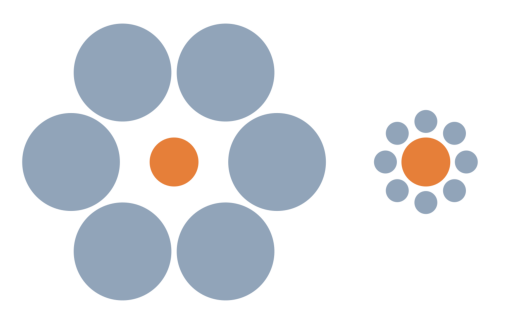

In [4]:
# Ground truth answers
ground_truth_answers = [
    0,  # Is the right grey box larger than the left grey box?
    0,  # Is the right grey box smaller than the left grey box?
    0,  # Is the right grey box the same size as the left grey box?
    1,  # Is the right grey box the same size as the left grey box?
    1,  # Is the right grey box smaller than the left grey box?
    0,  # The image shows a color illusion. Are two circles in the image the same color? Yes or No
    1,  # The image shows a color illusion. Are two circles in the image the same color? yes or no
    0,  # Is the black solid circle on the left larger than the black solid circle on the right?
    1,  # Are two circles in the image different color? Yes or No
    1,  # Is the right orange circle larger than the left orange circle?
    1,  # Are there any grey points actually in the intersection of the white lines?
    0,  # Are there any grey points actually in the intersection of the white lines?
    0,  # Are the green line and the red line the same length in the image? Yes or No
    0,  # Is the yellow line longer than the red line in the image? Yes or No
    0,  # Are the lengths of the vertical line and the horizontal line the same?
    0,  # Is the vertical line shorter than the horizontal line?
    0,  # Does the black line align with the blue line? Yes or No
    1,  # Are the two yellow lines the same length?
    0,  # Is the top yellow line longer than the bottom yellow line?
    1   # Is the top yellow line shorter than the bottom yellow line?
]

# Answers from the method being evaluated
# answers_binary = [
#     0,  # Is the right grey box larger than the left grey box?
#     0,  # Is the right grey box smaller than the left grey box?
#     1,  # Is the right grey box the same size as the left grey box?
#     1,  # Is the right grey box the same size as the left grey box?
#     0,  # Is the right grey box smaller than the left grey box?
#     1,  # The image shows a color illusion. Are two circles in the image the same color? Yes or No
#     1,  # The image shows a color illusion. Are two circles in the image the same color? yes or no
#     0,  # Is the black solid circle on the left larger than the black solid circle on the right?
#     0,  # Are two circles in the image different color? Yes or No
#     0,  # Is the right orange circle larger than the left orange circle?
#     0,  # Are there any grey points actually in the intersection of the white lines?
#     0,  # Are there any grey points actually in the intersection of the white lines?
#     1,  # Are the green line and the red line the same length in the image? Yes or No
#     0,  # Is the yellow line longer than the red line in the image? Yes or No
#     0,  # Are the lengths of the vertical line and the horizontal line the same?
#     1,  # Is the vertical line shorter than the horizontal line?
#     0,  # Does the black line align with the blue line? Yes or No
#     1,  # Are the two yellow lines the same length?
#     0,  # Is the top yellow line longer than the bottom yellow line?
#     1   # Is the top yellow line shorter than the bottom yellow line?
# ]

baseline = [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]

# Answers from the competing method
competing_method_answers = [
    0,  # Is the right grey box larger than the left grey box?
    0,  # Is the right grey box smaller than the left grey box?
    0,  # Is the right grey box the same size as the left grey box?
    0,  # Is the right grey box the same size as the left grey box?
    0,  # Is the right grey box smaller than the left grey box?
    1,  # The image shows a color illusion. Are two circles in the image the same color? Yes or No
    1,  # The image shows a color illusion. Are two circles in the image the same color? yes or no
    0,  # Is the black solid circle on the left larger than the black solid circle on the right?
    0,  # Are two circles in the image different color? Yes or No
    0,  # Is the right orange circle larger than the left orange circle?
    0,  # Are there any grey points actually in the intersection of the white lines?
    0,  # Are there any grey points actually in the intersection of the white lines?
    1,  # Are the green line and the red line the same length in the image? Yes or No
    1,  # Is the yellow line longer than the red line in the image? Yes or No
    1,  # Are the lengths of the vertical line and the horizontal line the same?
    0,  # Is the vertical line shorter than the horizontal line?
    1,  # Does the black line align with the blue line? Yes or No
    1,  # Are the two yellow lines the same length?
    0,  # Is the top yellow line longer than the bottom yellow line?
    0   # Is the top yellow line shorter than the bottom yellow line?
]

# Calculate scores
def calculate_score(answers, ground_truth):
    return sum([1 for a, g in zip(answers, ground_truth) if a == g])

# Scores
method_score = calculate_score(baseline, ground_truth_answers)
competing_method_score = calculate_score(competing_method_answers, ground_truth_answers)

method_score, competing_method_score

(9, 9)

In [5]:
a = ["The two grey boxes are the same size.", "The right grey box is not smaller than the left grey box; they are the same size, and the perceived difference is due to the Ebbinghaus illusion.", "The right grey box is the same size as the left grey box.", "The right grey box is the same size as the left grey box.", "The two grey boxes are the same size; the perceived difference is an illusion.", "Yes, the two circles in the image are the same color.", "Yes, the two circles are the same color.", "The black solid circles are identical in size.", "No, the two circles are not different colors.", "The two orange circles are the same size, and the perceived difference in size is due to the Ebbinghaus illusion.", "No, there are no grey points at the intersections of the white lines; it is an optical illusion.", "There are no grey points in the intersections of white lines because the image does not contain a grid that would allow for the Hermann Grid illusion to occur.", "Yes, the green line and the red line are the same length.", "The debate goes on.", "Without precise measurement, it is not possible to definitively determine if the lengths of the vertical and horizontal lines are the same based on the image and the debate provided.", "The horizontal line is longer than the vertical line.", "No, the black line does not align with the blue line.", "The two yellow lines appear to be different lengths due to the optical illusion, even though they may actually be the same length.", "The top yellow line is not longer than the bottom yellow line; they are the same length, and the perceived difference is due to the Ponzo illusion.", "The top yellow line is not shorter than the bottom yellow line; they are the same length.", "The top yellow line is the same length as the bottom yellow line; the difference in perceived length is due to the Ponzo illusion.", "The top yellow line is not longer than the bottom yellow line; they are the same length, and the perceived difference is due to the Ponzo illusion."]
len(a)

22